<a href="https://colab.research.google.com/github/cosmic643/black-hole-collision-simulation/blob/main/black_hole_merger_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [62]:
G = 1
mu_m = 1.0
sigma_m = 1.0
mu_r = 0.0
sigma_r = 1.0
DIMENSIONS = 3
n = 3 #Implies n^3 black holes
merger_radius = 0.01
timescale = 0.01

In [53]:
# '''index 0: x-axis
#    index 1: y-axis
#    index 2: z-axis
#    index 3: mass of the particle'''
# lattice = np.zeros((n,n,n,3))
# for i in range(n):
#   for j in range(n):
#     for k in range(n):
#       if i == 0 and j == 0 and k == 0:
#         lattice[i,j,k,0] = 0
#         lattice[i,j,k,1] = 0
#         lattice[i,j,k,2] = 0
#       else:
#         lattice[i,j,k,0] = lattice[max(i-1,0),j,k,0] + abs(np.random.normal(mu_r, sigma_r))
#         lattice[i,j,k,1] = lattice[i,max(j-1,0),k,1] + abs(np.random.normal(mu_r, sigma_r))
#         lattice[i,j,k,2] = lattice[i,j,max(k-1,0),2] + abs(np.random.normal(mu_r, sigma_r))

In [54]:
class BlackHole:
  coordinates = []
  mass = 0.0
  current_velocity = [0,0,0]
  def __init__(self, coordinates: list, mass: float):
    self.coordinates = coordinates
    self.mass = mass

  def get_coordinates(self):
    return self.coordinates

  def get_mass(self):
    return self.mass

  def get_position(self):
    return (self.x, self.y, self.z)

  def get_velocity(self):
    return self.current_velocity


  def set_coordinates(self, coordinates):
    self.coordinates = coordinates


  def set_velocity(self, current_velocity):
    self.current_velocity = current_velocity


  def display_blackhole_information(self):
    print("Coordinates(x,y,z): ",self.coordinates)
    print("Mass", self.mass)
    print("Velocity(x,y,z): ",self.current_velocity)
    print("\n")


In [63]:
class BlackHoleSystem:

  def __init__(self, mu_m, sigma_m, mu_r, sigma_r, n):
    self.system = np.ndarray((0),dtype = 'object')
    self.number = n**DIMENSIONS
    lattice = np.zeros((n,n,n,3))
    for i in range(n):
      for j in range(n):
        for k in range(n):
          if i == 0 and j == 0 and k == 0:
            lattice[i,j,k,0] = 0
            lattice[i,j,k,1] = 0
            lattice[i,j,k,2] = 0
          else:
            lattice[i,j,k,0] = lattice[max(i-1,0),j,k,0] + abs(np.random.normal(mu_r, sigma_r))
            lattice[i,j,k,1] = lattice[i,max(j-1,0),k,1] + abs(np.random.normal(mu_r, sigma_r))
            lattice[i,j,k,2] = lattice[i,j,max(k-1,0),2] + abs(np.random.normal(mu_r, sigma_r))

    for i in range(n):
      for j in range(n):
        for k in range(n):
          coordinates = [lattice[i,j,k,0], lattice[i,j,k,1], lattice[i,j,k,2]]
          mass = abs(np.random.normal(mu_m, sigma_m))
          self.system = np.append(self.system, BlackHole(coordinates, mass))

  def display_system_information(self):
    for blackhole in self.system:
      blackhole.display_blackhole_information()

  def number_of_blackholes(self):
    return self.system.size

  def add_blackhole(self,blackhole):
    self.system = np.append(self.system, blackhole)

  def remove_blackhole(self,blackhole: BlackHole):
    index = np.where(self.system == blackhole)[0]
    if index.size > 0:
      self.system = np.delete(self.system, index[0])

  def merge(self,merge_list: list):
  #Takes a list of: list of blackhole, each of which needs to be merged
    if(len(merge_list) == 0):
      return
    mass = []
    coordinates = []
    new_coordinates = []
    new_blackholes = []
    for blackholes in merge_list:
      new_coordinates = [0,0,0]
      new_mass = 0
      for blackhole in blackholes:
        new_mass += blackhole.get_mass()
        for i in range(DIMENSIONS):
          new_coordinates[i] += blackhole.get_mass()*blackhole.get_coordinates()[i]
      for k in range(DIMENSIONS):
        new_coordinates[k] = new_coordinates[k]/new_mass
      new_blackholes.append(BlackHole(new_coordinates, new_mass))
    for blackholes in merge_list:
      for blackhole in blackholes:
        self.remove_blackhole(blackhole)
    for blackhole in new_blackholes:
      self.add_blackhole(blackhole)


  def calculate_net_force(self, blackhole):
    """Calculate the net gravitational force on a given black hole."""
    # Initialize force as a 3-dimensional NumPy array
    force = np.zeros(3)
    for other in self.system:
      if blackhole is not other:
        r_vec = np.array(other.get_coordinates()) - np.array(blackhole.get_coordinates())
        distance = np.linalg.norm(r_vec)
        if distance > 0:
                # Calculate the gravitational force magnitude
          force_magnitude = G * blackhole.get_mass() * other.get_mass() / (distance ** 2)
                # Add force vector to the net force
          force += force_magnitude * (r_vec / distance)
    return force

  def iteration(self, timescale, merger_radius):
    """Update positions and velocities of all black holes using the Velocity Verlet method.

    Args:
        timescale (float): The time step for integration
        merger_radius (float): The radius within which black holes should merge

    The Velocity Verlet algorithm steps:
    1. Calculate initial accelerations
    2. Update positions using current velocities and accelerations
    3. Calculate new accelerations at new positions
    4. Update velocities using average of old and new accelerations
    """
    if self.number_of_blackholes() == 0:
        return

    # Store initial accelerations
    old_accelerations = {
        bh: self.calculate_net_force(bh) / bh.get_mass()
        for bh in self.system
    }

    # Step 1: Update positions
    for bh in self.system:
      current_pos = np.array(bh.get_coordinates())
      current_vel = np.array(bh.get_velocity())
      current_acc = old_accelerations[bh]

        # Update position using Velocity Verlet
      new_pos = (current_pos + current_vel * timescale + 0.5 * current_acc * (timescale ** 2))

      # Store half-step velocity for later use
      bh.half_step_velocity = current_vel + 0.5 * current_acc * timescale

      # Update position
      bh.set_coordinates(new_pos.tolist())

    # Calculate new accelerations at updated positions
    new_accelerations = {bh: self.calculate_net_force(bh) / bh.get_mass() for bh in self.system}

    # Step 2: Update velocities using averaged acceleration
    for bh in self.system:
        # Complete velocity update using average of old and new accelerations
      new_velocity = (bh.half_step_velocity + 0.5 * new_accelerations[bh] * timescale)
      bh.set_velocity(new_velocity.tolist())

      # Clean up temporary attribute
      if hasattr(bh, 'half_step_velocity'):
        delattr(bh, 'half_step_velocity')

    # Check for and handle mergers
    merge_list = self.check_mergers(merger_radius)
    if merge_list:
      self.merge(merge_list)

  def check_mergers(self, merger_radius):
    size = len(self.system)
    activated = np.ones((size), dtype=bool)
    add_system = []
    merge_list = []
    for i in range(size):
      if not activated[i]:
        continue
      for j in range(i+1, size):
        if not activated[j]:
          continue
        if np.linalg.norm(np.array(self.system[i].get_coordinates()) - np.array(self.system[j].get_coordinates())) < merger_radius:
          merge_list.append([self.system[i], self.system[j]])
    return merge_list

blackholesystem = BlackHoleSystem(mu_m, sigma_m, mu_r, sigma_r, n)
blackholesystem.display_system_information()

Coordinates(x,y,z):  [0.0, 0.0, 0.0]
Mass 0.21969986740848046
Velocity(x,y,z):  [0, 0, 0]


Coordinates(x,y,z):  [0.10264580650686798, 1.4036707880246477, 1.5940855298118866]
Mass 0.3741100840904694
Velocity(x,y,z):  [0, 0, 0]


Coordinates(x,y,z):  [0.7704140016153751, 0.05368224199494436, 2.0309985518390397]
Mass 0.21631638734114333
Velocity(x,y,z):  [0, 0, 0]


Coordinates(x,y,z):  [0.7581316331577261, 0.3538634860960389, 1.0706999908813102]
Mass 1.729682831209682
Velocity(x,y,z):  [0, 0, 0]


Coordinates(x,y,z):  [2.4930233776681696, 3.1955676816760406, 1.700335760939086]
Mass 1.2256929965961454
Velocity(x,y,z):  [0, 0, 0]


Coordinates(x,y,z):  [1.2558134930502873, 0.46023830543283223, 1.9990192963767397]
Mass 1.4859767170286666
Velocity(x,y,z):  [0, 0, 0]


Coordinates(x,y,z):  [0.6398401568230042, 1.5587816961655956, 1.0546173468907465]
Mass 0.18074743236533797
Velocity(x,y,z):  [0, 0, 0]


Coordinates(x,y,z):  [0.5184551282307396, 3.5710697930781277, 2.6499252157715985]
Mass 0.

In [64]:
blackholesystem.number_of_blackholes()

27

In [66]:
blackholesystem.display_system_information()

Coordinates(x,y,z):  [11.367719388286282, 13.67995413986865, 4.094876034145689]
Mass 0.21969986740848046
Velocity(x,y,z):  [2.0840567196599538, 2.759729967267228, 0.4601310790922896]


Coordinates(x,y,z):  [4.019964008555886, 6.368595367537817, 2.4342602580066197]
Mass 0.3741100840904694
Velocity(x,y,z):  [-0.5217924640870243, 0.20893794035020655, -1.12313058384655]


Coordinates(x,y,z):  [1.7881507637123966, 6.99042907346719, 6.71680982095944]
Mass 0.21631638734114333
Velocity(x,y,z):  [0.5152937299336672, 0.28903057175471714, 0.7607529580487961]


Coordinates(x,y,z):  [2.989969870283423, 4.128753171961061, 4.91184532869012]
Mass 1.2256929965961454
Velocity(x,y,z):  [1.4885803863384102, 1.5936786915272205, 0.7140903887978711]


Coordinates(x,y,z):  [-13.100592413374459, 35.69511115552962, -34.1405465682554]
Mass 1.4859767170286666
Velocity(x,y,z):  [-2.9185929169968317, 7.217606725897214, -7.393994536332055]


Coordinates(x,y,z):  [0.10341376012351358, 4.514893725402333, -0.3619380640

In [65]:
blackhole_count = []
time = []
for i in range(500):
  blackholesystem.iteration(timescale, merger_radius)
  blackhole_count.append(blackholesystem.number_of_blackholes())
  time.append(i*timescale)

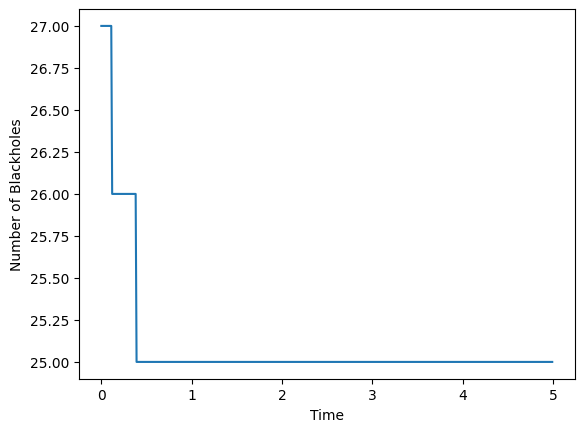

In [67]:
plt.plot(time, blackhole_count)
plt.xlabel("Time")
plt.ylabel("Number of Blackholes")
plt.show()